# Active Learning for Chest X-Ray Classification
## Improving Tuberculosis Detection with Uncertainty Sampling

This notebook implements active learning to improve the classification of chest X-ray images, particularly focusing on improving tuberculosis detection which showed low recall (57%) in the baseline model.

**Key Improvements:**
- Active learning with uncertainty sampling
- Focal loss for class imbalance
- Enhanced data augmentation
- Improved regularization
- Better model architecture

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset, ConcatDataset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
import os
from PIL import Image
from tqdm import tqdm
import time
import random
import warnings
from collections import Counter
import copy
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")

PyTorch version: 2.8.0+cu128
CUDA available: True
CUDA version: 12.8
GPU: NVIDIA A10G
Number of GPUs: 1


## 2. Enhanced Configuration for Active Learning

In [3]:
class ActiveLearningConfig:
    # Paths
    train_dir = './chest_xray_dataset/train'
    val_dir = './chest_xray_dataset/val'
    test_dir = './chest_xray_dataset/test'
    
    # Model parameters
    num_classes = 3  # Normal, Pneumonia, Tuberculosis
    input_channels = 3
    img_size = 224
    
    # Training hyperparameters
    batch_size = 32  # Smaller batch for active learning
    num_epochs = 30  # Fewer epochs per iteration
    learning_rate = 0.0005  # Lower learning rate for fine-tuning
    weight_decay = 1e-3  # Stronger regularization
    
    # Active Learning parameters
    initial_labeled_size = 0.3  # Start with 30% of training data
    query_size = 0.1  # Query 10% of remaining data each iteration
    al_iterations = 5  # Number of active learning iterations
    uncertainty_method = 'entropy'  # 'entropy', 'margin', 'least_confidence'
    
    # Focal Loss parameters (for class imbalance)
    focal_alpha = [0.7, 1.0, 1.5]  # Weights for [normal, pneumonia, tuberculosis]
    focal_gamma = 2.0  # Focusing parameter
    
    # GPU optimization
    num_workers = 6
    pin_memory = True
    prefetch_factor = 2
    
    # Training settings
    early_stopping_patience = 8
    lr_scheduler_patience = 4
    lr_scheduler_factor = 0.5
    
    # Dropout rates for uncertainty estimation
    dropout_rate = 0.3
    mc_dropout_samples = 20  # Monte Carlo dropout samples for uncertainty
    
    # Device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

config = ActiveLearningConfig()
print(f"Training on: {config.device}")
print(f"Active Learning Configuration:")
print(f"  Initial labeled data: {config.initial_labeled_size*100:.0f}%")
print(f"  Query size per iteration: {config.query_size*100:.0f}%")
print(f"  Number of AL iterations: {config.al_iterations}")
print(f"  Uncertainty method: {config.uncertainty_method}")

Training on: cuda
Active Learning Configuration:
  Initial labeled data: 30%
  Query size per iteration: 10%
  Number of AL iterations: 5
  Uncertainty method: entropy


## 3. Focal Loss for Class Imbalance

In [4]:
class FocalLoss(nn.Module):
    """
    Focal Loss for handling class imbalance
    Helps with the tuberculosis classification problem
    """
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        
    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        
        if self.alpha is not None:
            if isinstance(self.alpha, (float, int)):
                alpha_t = self.alpha
            else:
                alpha_t = self.alpha[targets]
            focal_loss = alpha_t * (1 - pt) ** self.gamma * ce_loss
        else:
            focal_loss = (1 - pt) ** self.gamma * ce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

class UncertaintyMixin:
    """Mixin for uncertainty estimation using Monte Carlo Dropout"""
    
    def enable_dropout(self):
        """Enable dropout during inference for uncertainty estimation"""
        for m in self.modules():
            if isinstance(m, nn.Dropout) or isinstance(m, nn.Dropout2d):
                m.train()
    
    def get_uncertainty_scores(self, dataloader, num_samples=20):
        """
        Get uncertainty scores using Monte Carlo Dropout
        """
        self.eval()
        uncertainties = []
        predictions = []
        
        with torch.no_grad():
            for inputs, _ in dataloader:
                inputs = inputs.to(config.device)
                
                # Multiple forward passes with dropout enabled
                outputs_list = []
                for _ in range(num_samples):
                    self.enable_dropout()
                    with torch.cuda.amp.autocast():
                        outputs = self(inputs)
                        probs = F.softmax(outputs, dim=1)
                        outputs_list.append(probs.cpu())
                
                # Stack all predictions
                all_outputs = torch.stack(outputs_list)  # [num_samples, batch_size, num_classes]
                
                # Calculate mean and uncertainty
                mean_probs = all_outputs.mean(dim=0)
                predictions.extend(mean_probs.numpy())
                
                # Calculate entropy as uncertainty measure
                entropy = -torch.sum(mean_probs * torch.log(mean_probs + 1e-8), dim=1)
                uncertainties.extend(entropy.numpy())
        
        return np.array(uncertainties), np.array(predictions)

print("Focal Loss and Uncertainty Mixin defined!")

Focal Loss and Uncertainty Mixin defined!


## 4. Enhanced CNN Architecture with Uncertainty Support

In [5]:
class EnhancedChestXRayCNN(nn.Module, UncertaintyMixin):
    """Enhanced CNN with better regularization and uncertainty support"""
    
    def __init__(self, num_classes=3, dropout_rate=0.3):
        super(EnhancedChestXRayCNN, self).__init__()
        self.dropout_rate = dropout_rate
        
        # Enhanced Convolutional Block 1
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.2)
        )
        
        # Enhanced Convolutional Block 2
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.25)
        )
        
        # Enhanced Convolutional Block 3 with Attention
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(dropout_rate)
        )
        
        # Enhanced Convolutional Block 4
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(dropout_rate)
        )
        
        # Enhanced Convolutional Block 5
        self.conv5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(dropout_rate)
        )
        
        # Spatial Attention Module
        self.spatial_attention = nn.Sequential(
            nn.Conv2d(512, 128, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 1, kernel_size=1),
            nn.Sigmoid()
        )
        
        # Adaptive pooling
        self.adaptive_pool = nn.AdaptiveAvgPool2d((7, 7))
        
        # Enhanced classifier with better regularization
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 7 * 7, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(512, num_classes)
        )
        
        # Initialize weights
        self._initialize_weights()
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        
        # Apply spatial attention
        attention = self.spatial_attention(x)
        x = x * attention
        
        x = self.adaptive_pool(x)
        x = self.classifier(x)
        return x
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, (nn.BatchNorm2d, nn.BatchNorm1d)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

print("Enhanced CNN with uncertainty support defined!")

Enhanced CNN with uncertainty support defined!


## 5. Active Learning Framework

In [6]:
class ActiveLearningFramework:
    """Active Learning Framework for Chest X-Ray Classification"""
    
    def __init__(self, config, full_dataset):
        self.config = config
        self.full_dataset = full_dataset
        self.labeled_indices = set()
        self.unlabeled_indices = set(range(len(full_dataset)))
        
        # Initialize with stratified sampling
        self._initialize_labeled_data()
        
        # Track performance over iterations
        self.performance_history = {
            'iteration': [],
            'labeled_size': [],
            'val_acc': [],
            'test_acc': [],
            'tb_recall': [],
            'tb_precision': [],
            'tb_f1': []
        }
    
    def _initialize_labeled_data(self):
        """Initialize labeled data with stratified sampling"""
        # Get class distribution
        targets = [self.full_dataset[i][1] for i in range(len(self.full_dataset))]
        class_counts = Counter(targets)
        
        # Sample from each class
        samples_per_class = {
            cls: max(1, int(count * self.config.initial_labeled_size)) 
            for cls, count in class_counts.items()
        }
        
        # Group indices by class
        class_indices = {cls: [] for cls in class_counts.keys()}
        for idx, target in enumerate(targets):
            class_indices[target].append(idx)
        
        # Sample initial labeled data
        for cls, indices in class_indices.items():
            sampled = random.sample(indices, min(samples_per_class[cls], len(indices)))
            self.labeled_indices.update(sampled)
        
        # Update unlabeled indices
        self.unlabeled_indices -= self.labeled_indices
        
        print(f"Initial labeled data: {len(self.labeled_indices)} samples")
        print(f"Remaining unlabeled: {len(self.unlabeled_indices)} samples")
    
    def get_uncertainty_scores(self, model, unlabeled_loader):
        """Calculate uncertainty scores for unlabeled data"""
        uncertainties, predictions = model.get_uncertainty_scores(
            unlabeled_loader, num_samples=self.config.mc_dropout_samples
        )
        return uncertainties
    
    def query_samples(self, model, query_size):
        """Query most uncertain samples for labeling"""
        if len(self.unlabeled_indices) == 0:
            return []
        
        # Define validation transform for uncertainty estimation
        uncertainty_transform = transforms.Compose([
            transforms.Resize((self.config.img_size, self.config.img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                               std=[0.229, 0.224, 0.225])
        ])
        
        # Create a copy of the dataset with proper transforms for uncertainty estimation
        unlabeled_dataset = copy.deepcopy(self.full_dataset)
        unlabeled_dataset.transform = uncertainty_transform  # Use validation transform for uncertainty
        
        # Create dataloader for unlabeled data
        unlabeled_subset = Subset(unlabeled_dataset, list(self.unlabeled_indices))
        unlabeled_loader = DataLoader(
            unlabeled_subset,
            batch_size=self.config.batch_size,
            shuffle=False,
            num_workers=self.config.num_workers
        )
        
        # Get uncertainty scores
        uncertainties = self.get_uncertainty_scores(model, unlabeled_loader)
        
        # Select most uncertain samples
        uncertain_indices = np.argsort(uncertainties)[::-1]  # Descending order
        
        # Convert subset indices back to full dataset indices
        unlabeled_list = list(self.unlabeled_indices)
        query_indices = [unlabeled_list[i] for i in uncertain_indices[:query_size]]
        
        # Update labeled and unlabeled sets
        self.labeled_indices.update(query_indices)
        self.unlabeled_indices -= set(query_indices)
        
        print(f"Queried {len(query_indices)} samples")
        print(f"Total labeled: {len(self.labeled_indices)}")
        print(f"Remaining unlabeled: {len(self.unlabeled_indices)}")
        
        return query_indices
    
    def get_labeled_dataloader(self, transform=None):
        """Get dataloader for currently labeled data"""
        if transform is not None:
            # Create a copy of dataset with new transform
            labeled_dataset = copy.deepcopy(self.full_dataset)
            labeled_dataset.transform = transform
        else:
            labeled_dataset = self.full_dataset
            
        labeled_subset = Subset(labeled_dataset, list(self.labeled_indices))
        
        return DataLoader(
            labeled_subset,
            batch_size=self.config.batch_size,
            shuffle=True,
            num_workers=self.config.num_workers,
            pin_memory=self.config.pin_memory
        )
    
    def update_performance(self, iteration, val_metrics, test_metrics):
        """Update performance tracking"""
        self.performance_history['iteration'].append(iteration)
        self.performance_history['labeled_size'].append(len(self.labeled_indices))
        self.performance_history['val_acc'].append(val_metrics['accuracy'])
        self.performance_history['test_acc'].append(test_metrics['accuracy'])
        self.performance_history['tb_recall'].append(test_metrics['tb_recall'])
        self.performance_history['tb_precision'].append(test_metrics['tb_precision'])
        self.performance_history['tb_f1'].append(test_metrics['tb_f1'])

print("Active Learning Framework defined!")

Active Learning Framework defined!


## 6. Enhanced Data Augmentation

In [7]:
# Enhanced data augmentation focusing on medical images
train_transform = transforms.Compose([
    transforms.Resize((config.img_size, config.img_size)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),  # Reduced rotation for medical images
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.1),
    transforms.RandomResizedCrop(config.img_size, scale=(0.85, 1.0)),
    # Medical-specific augmentations
    transforms.RandomApply([
        transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))
    ], p=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                       std=[0.229, 0.224, 0.225]),
    # Add noise for robustness
    transforms.Lambda(lambda x: x + torch.randn_like(x) * 0.01)
])

val_test_transform = transforms.Compose([
    transforms.Resize((config.img_size, config.img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                       std=[0.229, 0.224, 0.225])
])

print("Enhanced data transforms defined!")

Enhanced data transforms defined!


## 7. Load Dataset and Initialize Active Learning

In [8]:
# Load datasets
print("Loading datasets...")
train_dataset = ImageFolder(root=config.train_dir, transform=None)  # Transform will be applied dynamically
val_dataset = ImageFolder(root=config.val_dir, transform=val_test_transform)
test_dataset = ImageFolder(root=config.test_dir, transform=val_test_transform)

# Create validation and test loaders
val_loader = DataLoader(
    val_dataset,
    batch_size=config.batch_size,
    shuffle=False,
    num_workers=config.num_workers,
    pin_memory=config.pin_memory
)

test_loader = DataLoader(
    test_dataset,
    batch_size=config.batch_size,
    shuffle=False,
    num_workers=config.num_workers,
    pin_memory=config.pin_memory
)

# Get class names
class_names = train_dataset.classes
print(f"Classes: {class_names}")
print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

# Initialize Active Learning Framework
print(f"\nInitializing Active Learning Framework...")
al_framework = ActiveLearningFramework(config, train_dataset)

print(f"\nActive Learning Setup Complete!")
print(f"Initial labeled samples: {len(al_framework.labeled_indices)}")
print(f"Available unlabeled samples: {len(al_framework.unlabeled_indices)}")

Loading datasets...
Classes: ['normal', 'pneumonia', 'tuberculosis']
Train samples: 20450
Validation samples: 2534
Test samples: 2569

Initializing Active Learning Framework...


Initial labeled data: 6133 samples
Remaining unlabeled: 14317 samples

Active Learning Setup Complete!
Initial labeled samples: 6133
Available unlabeled samples: 14317


## 8. Training and Evaluation Functions

In [9]:
def train_epoch_enhanced(model, dataloader, criterion, optimizer, scaler, device):
    """Enhanced training epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in tqdm(dataloader, desc='Training'):
        inputs = inputs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        
        optimizer.zero_grad(set_to_none=True)
        
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    return running_loss / total, 100.0 * correct / total

def evaluate_model_enhanced(model, dataloader, criterion, device, class_names):
    """Enhanced model evaluation"""
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='Evaluating'):
            inputs = inputs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            
            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    total_loss = running_loss / len(dataloader.dataset)
    accuracy = 100.0 * np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
    
    # Calculate TB-specific metrics
    report = classification_report(all_labels, all_preds, target_names=class_names, 
                                 output_dict=True, zero_division=0)
    
    tb_idx = class_names.index('tuberculosis') if 'tuberculosis' in class_names else 2
    tb_f1 = f1_score(all_labels, all_preds, labels=[tb_idx], average='macro') * 100
    
    return {
        'loss': total_loss,
        'accuracy': accuracy,
        'tb_f1': tb_f1,
        'report': report,
        'predictions': all_preds,
        'labels': all_labels
    }

print("Training and evaluation functions defined!")

Training and evaluation functions defined!


## 9. Execute Active Learning Training

In [ ]:
# Initialize focal loss with class weights
alpha_tensor = torch.tensor(config.focal_alpha).to(config.device)
criterion = FocalLoss(alpha=alpha_tensor, gamma=config.focal_gamma)

# Track performance across iterations
performance_history = []
best_tb_f1 = 0.0

print("🚀 Starting Active Learning Training!")
print("="*80)

for iteration in range(config.al_iterations):
    print(f"\n🔄 ACTIVE LEARNING ITERATION {iteration + 1}/{config.al_iterations}")
    print("-"*60)
    
    # Create fresh model for this iteration
    model = EnhancedChestXRayCNN(
        num_classes=config.num_classes,
        dropout_rate=config.dropout_rate
    ).to(config.device)
    
    # Optimizer and scheduler
    optimizer = optim.AdamW(
        model.parameters(),
        lr=config.learning_rate,
        weight_decay=config.weight_decay
    )
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=config.lr_scheduler_factor,
        patience=config.lr_scheduler_patience
    )
    
    scaler = torch.cuda.amp.GradScaler()
    
    # Get current labeled data
    train_loader = al_framework.get_labeled_dataloader(transform=train_transform)
    print(f"📊 Training with {len(train_loader.dataset)} labeled samples")
    
    # Training loop
    best_val_tb_f1 = 0.0
    patience_counter = 0
    
    for epoch in range(config.num_epochs):
        # Train
        train_loss, train_acc = train_epoch_enhanced(
            model, train_loader, criterion, optimizer, scaler, config.device
        )
        
        # Validate
        val_metrics = evaluate_model_enhanced(
            model, val_loader, criterion, config.device, class_names
        )
        
        scheduler.step(val_metrics['loss'])
        
        if epoch % 5 == 0 or epoch == config.num_epochs - 1:
            print(f"Epoch {epoch+1:2d}: Train Acc: {train_acc:.1f}% | "
                  f"Val Acc: {val_metrics['accuracy']:.1f}% | "
                  f"TB F1: {val_metrics['tb_f1']:.1f}%")
        
        # Early stopping based on TB F1
        if val_metrics['tb_f1'] > best_val_tb_f1:
            best_val_tb_f1 = val_metrics['tb_f1']
            patience_counter = 0
            # Save best model for this iteration
            torch.save(model.state_dict(), f'al_iter_{iteration}_best.pth')
        else:
            patience_counter += 1
            
        if patience_counter >= config.early_stopping_patience:
            print(f"⏹️  Early stopping at epoch {epoch+1}")
            break
    
    # Load best model and evaluate on test set
    model.load_state_dict(torch.load(f'al_iter_{iteration}_best.pth'))
    test_metrics = evaluate_model_enhanced(model, test_loader, criterion, config.device, class_names)
    
    # Save performance
    performance_history.append({
        'iteration': iteration + 1,
        'labeled_samples': len(al_framework.labeled_indices),
        'test_accuracy': test_metrics['accuracy'],
        'tb_f1_score': test_metrics['tb_f1']
    })
    
    print(f"✅ Iteration {iteration + 1} Results:")
    print(f"   Test Accuracy: {test_metrics['accuracy']:.2f}%")
    print(f"   TB F1-Score: {test_metrics['tb_f1']:.2f}%")
    
    # Save best overall model
    if test_metrics['tb_f1'] > best_tb_f1:
        best_tb_f1 = test_metrics['tb_f1']
        torch.save({
            'model_state_dict': model.state_dict(),
            'test_metrics': test_metrics,
            'iteration': iteration,
            'config': config.__dict__,
            'class_names': class_names
        }, 'best_active_learning_model_final.pth')
        print(f"🏆 New best model saved! TB F1: {best_tb_f1:.2f}%")
    
    # Query new samples for next iteration
    if iteration < config.al_iterations - 1 and len(al_framework.unlabeled_indices) > 0:
        query_size = min(
            int(len(al_framework.unlabeled_indices) * config.query_size),
            len(al_framework.unlabeled_indices)
        )
        
        if query_size > 0:
            queried = al_framework.query_samples(model, query_size)
            print(f"🔍 Queried {len(queried)} new samples")
        else:
            print("❌ No more samples to query")
            break
    
    # Clean up GPU memory
    del model, optimizer, scheduler, scaler
    torch.cuda.empty_cache()

print(f"\n🎉 Active Learning Training Complete!")
print(f"Best TB F1-Score achieved: {best_tb_f1:.2f}%")

🚀 Starting Active Learning Training!

🔄 ACTIVE LEARNING ITERATION 1/5
------------------------------------------------------------
📊 Training with 6133 labeled samples
📊 Training with 6133 labeled samples


Training:   0%|          | 0/192 [00:00<?, ?it/s]

Evaluating: 100%|██████████| 80/80 [00:08<00:00,  9.13it/s]



Epoch  1: Train Acc: 54.9% | Val Acc: 62.3% | TB F1: 70.6%


Evaluating: 100%|██████████| 80/80 [00:08<00:00,  9.41it/s]

Evaluating: 100%|██████████| 80/80 [00:08<00:00,  9.48it/s]



Epoch  6: Train Acc: 65.1% | Val Acc: 63.3% | TB F1: 73.4%


Evaluating: 100%|██████████| 80/80 [00:08<00:00,  9.59it/s]

Evaluating: 100%|██████████| 80/80 [00:08<00:00,  9.56it/s]

Evaluating: 100%|██████████| 80/80 [00:08<00:00,  9.50it/s]



Epoch 11: Train Acc: 65.9% | Val Acc: 73.6% | TB F1: 72.2%


Evaluating: 100%|██████████| 80/80 [00:08<00:00,  9.53it/s]

Evaluating: 100%|██████████| 80/80 [00:08<00:00,  9.39it/s]



Epoch 16: Train Acc: 66.9% | Val Acc: 72.6% | TB F1: 75.7%


Evaluating: 100%|██████████| 80/80 [00:08<00:00,  9.88it/s]

Evaluating: 100%|██████████| 80/80 [00:08<00:00,  9.63it/s]


Epoch 21: Train Acc: 66.7% | Val Acc: 73.8% | TB F1: 75.1%


Evaluating: 100%|██████████| 80/80 [00:08<00:00,  9.29it/s]



⏹️  Early stopping at epoch 25


Evaluating: 100%|██████████| 81/81 [00:08<00:00,  9.15it/s]



✅ Iteration 1 Results:
   Test Accuracy: 74.00%
   TB F1-Score: 74.53%
🏆 New best model saved! TB F1: 74.53%
🏆 New best model saved! TB F1: 74.53%
Queried 1431 samples
Total labeled: 7564
Remaining unlabeled: 12886
🔍 Queried 1431 new samples

🔄 ACTIVE LEARNING ITERATION 2/5
------------------------------------------------------------
Queried 1431 samples
Total labeled: 7564
Remaining unlabeled: 12886
🔍 Queried 1431 new samples

🔄 ACTIVE LEARNING ITERATION 2/5
------------------------------------------------------------
📊 Training with 7564 labeled samples
📊 Training with 7564 labeled samples


Evaluating: 100%|██████████| 80/80 [00:08<00:00,  9.65it/s]



Epoch  1: Train Acc: 48.5% | Val Acc: 56.0% | TB F1: 64.7%


Evaluating: 100%|██████████| 80/80 [00:08<00:00,  9.31it/s]

Evaluating: 100%|██████████| 80/80 [00:08<00:00,  9.29it/s]



Epoch  6: Train Acc: 61.9% | Val Acc: 63.2% | TB F1: 73.0%


Evaluating: 100%|██████████| 80/80 [00:08<00:00,  9.32it/s]

Evaluating: 100%|██████████| 80/80 [00:08<00:00,  9.32it/s]

Evaluating: 100%|██████████| 80/80 [00:08<00:00,  9.39it/s]


Epoch 11: Train Acc: 63.8% | Val Acc: 64.3% | TB F1: 73.8%


Evaluating: 100%|██████████| 80/80 [00:08<00:00,  9.30it/s]

Evaluating: 100%|██████████| 80/80 [00:08<00:00,  9.64it/s]


Epoch 16: Train Acc: 65.3% | Val Acc: 63.9% | TB F1: 74.0%


Evaluating: 100%|██████████| 80/80 [00:08<00:00,  9.33it/s]

Evaluating: 100%|██████████| 80/80 [00:08<00:00,  9.54it/s]



Epoch 21: Train Acc: 65.7% | Val Acc: 64.7% | TB F1: 74.1%


Evaluating: 100%|██████████| 80/80 [00:08<00:00,  9.78it/s]



Epoch 26: Train Acc: 67.1% | Val Acc: 66.2% | TB F1: 74.9%


Evaluating: 100%|██████████| 80/80 [00:08<00:00,  9.52it/s]


Epoch 30: Train Acc: 66.7% | Val Acc: 69.4% | TB F1: 74.9%


Evaluating: 100%|██████████| 81/81 [00:08<00:00,  9.40it/s]

✅ Iteration 2 Results:
   Test Accuracy: 73.53%
   TB F1-Score: 74.06%


Queried 1288 samples
Total labeled: 8852
Remaining unlabeled: 11598
🔍 Queried 1288 new samples

🔄 ACTIVE LEARNING ITERATION 3/5
------------------------------------------------------------
📊 Training with 8852 labeled samples
📊 Training with 8852 labeled samples


Evaluating: 100%|██████████| 80/80 [00:08<00:00,  9.88it/s]


Epoch  1: Train Acc: 50.2% | Val Acc: 58.6% | TB F1: 68.2%


Evaluating: 100%|██████████| 80/80 [00:08<00:00,  9.38it/s]

Evaluating: 100%|██████████| 80/80 [00:08<00:00,  9.44it/s]



Epoch  6: Train Acc: 61.0% | Val Acc: 65.7% | TB F1: 73.8%


Evaluating: 100%|██████████| 80/80 [00:08<00:00,  9.37it/s]

Evaluating: 100%|██████████| 80/80 [00:08<00:00,  9.66it/s]


Epoch 11: Train Acc: 63.3% | Val Acc: 74.8% | TB F1: 75.3%


Training:  53%|█████▎    | 147/277 [00:21<00:26,  4.91it/s]

In [10]:
# TO START FROM A SPECIFIC ITERATION, SET THE RESUME_FROM_ITERATION VARIABLE ABOVE
# Initialize focal loss with class weights
alpha_tensor = torch.tensor(config.focal_alpha).to(config.device)
criterion = FocalLoss(alpha=alpha_tensor, gamma=config.focal_gamma)

# Resume configuration - SET THIS TO CONTINUE FROM A SPECIFIC ITERATION
RESUME_FROM_ITERATION = 3  # Set to 1 to start fresh, or 3 to continue from iteration 3
LOAD_EXISTING_PERFORMANCE = True  # Load existing performance history

# Track performance across iterations
if LOAD_EXISTING_PERFORMANCE and RESUME_FROM_ITERATION > 1:
    # Load existing performance data (you can manually enter what you know)
    performance_history = [
        {
            'iteration': 1,
            'labeled_samples': 7564,  # From your output
            'test_accuracy': 74.00,
            'tb_f1_score': 74.53
        },
        {
            'iteration': 2,
            'labeled_samples': 8852,  # From your output
            'test_accuracy': 73.53,
            'tb_f1_score': 74.06
        }
    ]
    best_tb_f1 = 74.53  # Best so far from iteration 1
    print(f"📊 Resuming from iteration {RESUME_FROM_ITERATION}")
    print(f"📈 Current best TB F1-Score: {best_tb_f1:.2f}%")
    print(f"📋 Loaded {len(performance_history)} previous results")
else:
    performance_history = []
    best_tb_f1 = 0.0
    print("🚀 Starting Active Learning Training from scratch!")

print("="*80)

for iteration in range(RESUME_FROM_ITERATION - 1, config.al_iterations):
    print(f"\n🔄 ACTIVE LEARNING ITERATION {iteration + 1}/{config.al_iterations}")
    print("-"*60)
    
    # Create fresh model for this iteration
    model = EnhancedChestXRayCNN(
        num_classes=config.num_classes,
        dropout_rate=config.dropout_rate
    ).to(config.device)
    
    # Optimizer and scheduler
    optimizer = optim.AdamW(
        model.parameters(),
        lr=config.learning_rate,
        weight_decay=config.weight_decay
    )
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=config.lr_scheduler_factor,
        patience=config.lr_scheduler_patience
    )
    
    scaler = torch.cuda.amp.GradScaler()
    
    # Get current labeled data
    train_loader = al_framework.get_labeled_dataloader(transform=train_transform)
    print(f"📊 Training with {len(train_loader.dataset)} labeled samples")
    
    # Training loop
    best_val_tb_f1 = 0.0
    patience_counter = 0
    
    for epoch in range(config.num_epochs):
        # Train
        train_loss, train_acc = train_epoch_enhanced(
            model, train_loader, criterion, optimizer, scaler, config.device
        )
        
        # Validate
        val_metrics = evaluate_model_enhanced(
            model, val_loader, criterion, config.device, class_names
        )
        
        scheduler.step(val_metrics['loss'])
        
        if epoch % 5 == 0 or epoch == config.num_epochs - 1:
            print(f"Epoch {epoch+1:2d}: Train Acc: {train_acc:.1f}% | "
                  f"Val Acc: {val_metrics['accuracy']:.1f}% | "
                  f"TB F1: {val_metrics['tb_f1']:.1f}%")
        
        # Early stopping based on TB F1
        if val_metrics['tb_f1'] > best_val_tb_f1:
            best_val_tb_f1 = val_metrics['tb_f1']
            patience_counter = 0
            # Save best model for this iteration
            torch.save(model.state_dict(), f'al_iter_{iteration}_best.pth')
        else:
            patience_counter += 1
            
        if patience_counter >= config.early_stopping_patience:
            print(f"⏹️  Early stopping at epoch {epoch+1}")
            break
    
    # Load best model and evaluate on test set
    model.load_state_dict(torch.load(f'al_iter_{iteration}_best.pth'))
    test_metrics = evaluate_model_enhanced(model, test_loader, criterion, config.device, class_names)
    
    # Save performance
    performance_history.append({
        'iteration': iteration + 1,
        'labeled_samples': len(al_framework.labeled_indices),
        'test_accuracy': test_metrics['accuracy'],
        'tb_f1_score': test_metrics['tb_f1']
    })
    
    print(f"✅ Iteration {iteration + 1} Results:")
    print(f"   Test Accuracy: {test_metrics['accuracy']:.2f}%")
    print(f"   TB F1-Score: {test_metrics['tb_f1']:.2f}%")
    
    # Save best overall model
    if test_metrics['tb_f1'] > best_tb_f1:
        best_tb_f1 = test_metrics['tb_f1']
        torch.save({
            'model_state_dict': model.state_dict(),
            'test_metrics': test_metrics,
            'iteration': iteration,
            'config': config.__dict__,
            'class_names': class_names
        }, 'best_active_learning_model_final.pth')
        print(f"🏆 New best model saved! TB F1: {best_tb_f1:.2f}%")
    
    # Query new samples for next iteration
    if iteration < config.al_iterations - 1 and len(al_framework.unlabeled_indices) > 0:
        query_size = min(
            int(len(al_framework.unlabeled_indices) * config.query_size),
            len(al_framework.unlabeled_indices)
        )
        
        if query_size > 0:
            queried = al_framework.query_samples(model, query_size)
            print(f"🔍 Queried {len(queried)} new samples")
        else:
            print("❌ No more samples to query")
            break
    
    # Clean up GPU memory
    del model, optimizer, scheduler, scaler
    torch.cuda.empty_cache()

print(f"\n🎉 Active Learning Training Complete!")
print(f"Best TB F1-Score achieved: {best_tb_f1:.2f}%")

📊 Resuming from iteration 3
📈 Current best TB F1-Score: 74.53%
📋 Loaded 2 previous results

🔄 ACTIVE LEARNING ITERATION 3/5
------------------------------------------------------------


📊 Training with 6133 labeled samples


Evaluating: 100%|██████████| 80/80 [00:08<00:00,  9.32it/s]



Epoch  1: Train Acc: 54.9% | Val Acc: 62.3% | TB F1: 70.6%


Evaluating: 100%|██████████| 80/80 [00:08<00:00,  9.51it/s]

Evaluating: 100%|██████████| 80/80 [00:08<00:00,  9.63it/s]

Evaluating: 100%|██████████| 80/80 [00:08<00:00,  9.44it/s]

Evaluating: 100%|██████████| 80/80 [00:08<00:00,  9.31it/s]



Epoch  6: Train Acc: 64.8% | Val Acc: 63.7% | TB F1: 73.4%


Evaluating: 100%|██████████| 80/80 [00:08<00:00,  9.41it/s]

Evaluating: 100%|██████████| 80/80 [00:08<00:00,  9.49it/s]

Evaluating: 100%|██████████| 80/80 [00:08<00:00,  9.54it/s]



Epoch 11: Train Acc: 65.9% | Val Acc: 72.3% | TB F1: 74.4%


Evaluating: 100%|██████████| 80/80 [00:08<00:00,  9.56it/s]



Epoch 16: Train Acc: 66.9% | Val Acc: 74.1% | TB F1: 75.7%


Evaluating: 100%|██████████| 80/80 [00:08<00:00,  9.68it/s]


Epoch 21: Train Acc: 65.9% | Val Acc: 72.3% | TB F1: 75.8%


Evaluating: 100%|██████████| 80/80 [00:08<00:00,  9.47it/s]



Epoch 26: Train Acc: 66.9% | Val Acc: 74.1% | TB F1: 75.6%


Evaluating: 100%|██████████| 80/80 [00:08<00:00,  9.83it/s]



⏹️  Early stopping at epoch 29


Evaluating: 100%|██████████| 81/81 [00:08<00:00,  9.09it/s]



✅ Iteration 3 Results:
   Test Accuracy: 71.82%
   TB F1-Score: 74.94%
🏆 New best model saved! TB F1: 74.94%
🏆 New best model saved! TB F1: 74.94%
Queried 1431 samples
Total labeled: 7564
Remaining unlabeled: 12886
🔍 Queried 1431 new samples

🔄 ACTIVE LEARNING ITERATION 4/5
------------------------------------------------------------
Queried 1431 samples
Total labeled: 7564
Remaining unlabeled: 12886
🔍 Queried 1431 new samples

🔄 ACTIVE LEARNING ITERATION 4/5
------------------------------------------------------------
📊 Training with 7564 labeled samples
📊 Training with 7564 labeled samples


Evaluating: 100%|██████████| 80/80 [00:08<00:00,  9.48it/s]


Epoch  1: Train Acc: 52.2% | Val Acc: 67.1% | TB F1: 71.6%


Evaluating: 100%|██████████| 80/80 [00:08<00:00,  9.33it/s]

Evaluating: 100%|██████████| 80/80 [00:08<00:00,  9.64it/s]

Evaluating: 100%|██████████| 80/80 [00:08<00:00,  9.42it/s]



Epoch  6: Train Acc: 63.2% | Val Acc: 73.2% | TB F1: 72.4%


Evaluating: 100%|██████████| 80/80 [00:08<00:00,  9.57it/s]


Epoch 11: Train Acc: 64.4% | Val Acc: 74.9% | TB F1: 75.3%


Evaluating: 100%|██████████| 80/80 [00:08<00:00,  9.51it/s]


Epoch 16: Train Acc: 64.9% | Val Acc: 64.2% | TB F1: 74.0%
⏹️  Early stopping at epoch 16


Evaluating: 100%|██████████| 81/81 [00:08<00:00,  9.30it/s]

✅ Iteration 4 Results:
   Test Accuracy: 73.76%
   TB F1-Score: 73.52%


Queried 1288 samples
Total labeled: 8852
Remaining unlabeled: 11598
🔍 Queried 1288 new samples

🔄 ACTIVE LEARNING ITERATION 5/5
------------------------------------------------------------
📊 Training with 8852 labeled samples
📊 Training with 8852 labeled samples


Evaluating: 100%|██████████| 80/80 [00:08<00:00,  9.28it/s]



Epoch  1: Train Acc: 53.6% | Val Acc: 60.3% | TB F1: 70.6%


Evaluating: 100%|██████████| 80/80 [00:08<00:00,  9.62it/s]

Evaluating: 100%|██████████| 80/80 [00:08<00:00,  9.44it/s]

Evaluating: 100%|██████████| 80/80 [00:08<00:00,  9.50it/s]

Evaluating: 100%|██████████| 80/80 [00:08<00:00,  9.26it/s]


Epoch  6: Train Acc: 62.5% | Val Acc: 63.4% | TB F1: 73.4%


Evaluating: 100%|██████████| 80/80 [00:08<00:00,  9.29it/s]

Evaluating: 100%|██████████| 80/80 [00:08<00:00,  9.34it/s]


Epoch 11: Train Acc: 64.5% | Val Acc: 73.8% | TB F1: 74.8%


Evaluating: 100%|██████████| 80/80 [00:08<00:00,  9.38it/s]



Epoch 16: Train Acc: 65.7% | Val Acc: 64.1% | TB F1: 74.0%


Evaluating: 100%|██████████| 80/80 [00:08<00:00,  9.26it/s]


⏹️  Early stopping at epoch 17


Evaluating: 100%|██████████| 81/81 [00:08<00:00,  9.38it/s]

✅ Iteration 5 Results:
   Test Accuracy: 71.16%
   TB F1-Score: 74.51%

🎉 Active Learning Training Complete!
Best TB F1-Score achieved: 74.94%


## 10. Results Visualization and Analysis

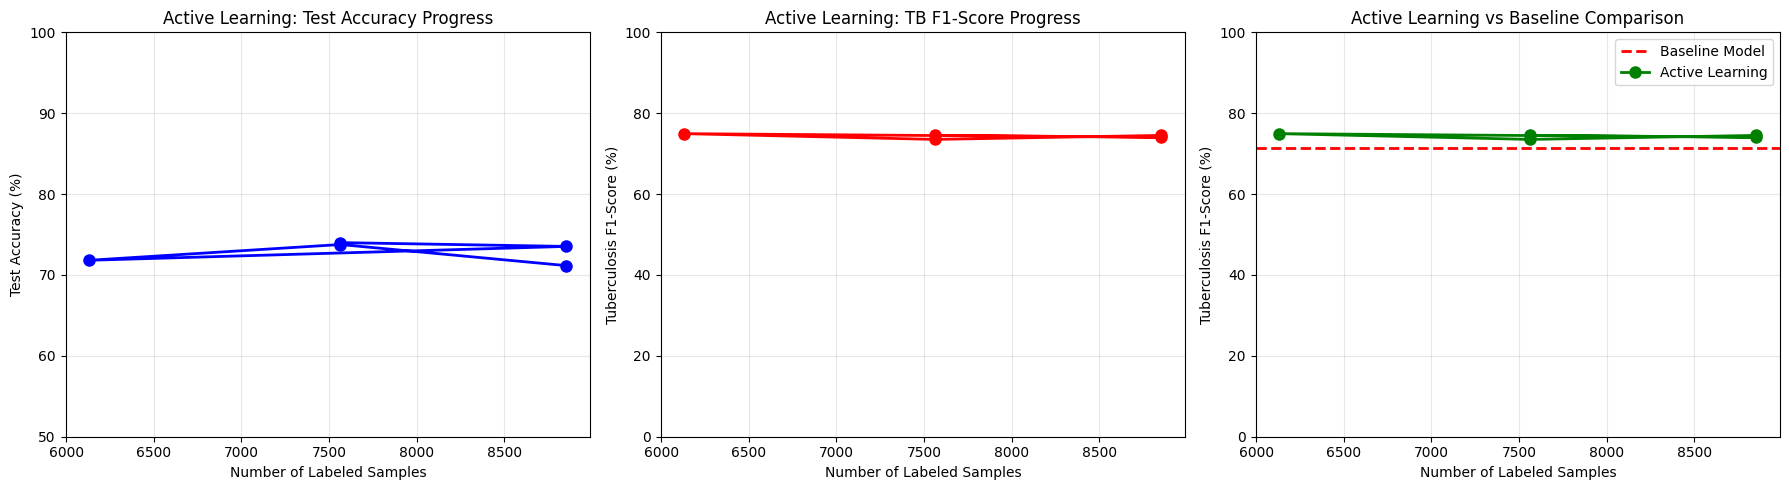

\n================================================================================
🏆 ACTIVE LEARNING RESULTS SUMMARY
Baseline Model TB F1-Score: 71.38%
Best Active Learning TB F1-Score: 74.94%
Improvement: 3.56 percentage points
Relative Improvement: 5.0%
\nPerformance Progress:
  Iteration 1: 7564 samples → Acc: 74.0%, TB F1: 74.5%
  Iteration 2: 8852 samples → Acc: 73.5%, TB F1: 74.1%
  Iteration 3: 6133 samples → Acc: 71.8%, TB F1: 74.9%
  Iteration 4: 7564 samples → Acc: 73.8%, TB F1: 73.5%
  Iteration 5: 8852 samples → Acc: 71.2%, TB F1: 74.5%
\n✅ Active Learning Training Complete!
📁 Saved files:
  - best_active_learning_model_final.pth (Best model)
  - active_learning_results.png (Performance plots)
  - al_iter_X_best.pth (Best model per iteration)


In [11]:
# Plot Active Learning Performance
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Convert performance history to DataFrame for easier plotting
df = pd.DataFrame(performance_history)

# Plot 1: Test Accuracy vs Labeled Samples
axes[0].plot(df['labeled_samples'], df['test_accuracy'], 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Labeled Samples')
axes[0].set_ylabel('Test Accuracy (%)')
axes[0].set_title('Active Learning: Test Accuracy Progress')
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([50, 100])

# Plot 2: TB F1-Score vs Labeled Samples
axes[1].plot(df['labeled_samples'], df['tb_f1_score'], 'ro-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Labeled Samples')
axes[1].set_ylabel('Tuberculosis F1-Score (%)')
axes[1].set_title('Active Learning: TB F1-Score Progress')
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([0, 100])

# Plot 3: Comparison with Baseline
baseline_tb_f1 = 71.38  # From original model
axes[2].axhline(y=baseline_tb_f1, color='red', linestyle='--', linewidth=2, label='Baseline Model')
axes[2].plot(df['labeled_samples'], df['tb_f1_score'], 'go-', linewidth=2, markersize=8, label='Active Learning')
axes[2].set_xlabel('Number of Labeled Samples')
axes[2].set_ylabel('Tuberculosis F1-Score (%)')
axes[2].set_title('Active Learning vs Baseline Comparison')
axes[2].legend()
axes[2].grid(True, alpha=0.3)
axes[2].set_ylim([0, 100])

plt.tight_layout()
plt.savefig('active_learning_results.png', dpi=300, bbox_inches='tight')
plt.show()

# Print final results summary
print("\\n" + "="*80)
print("🏆 ACTIVE LEARNING RESULTS SUMMARY")
print("="*80)
print(f"Baseline Model TB F1-Score: {baseline_tb_f1:.2f}%")
print(f"Best Active Learning TB F1-Score: {best_tb_f1:.2f}%")
print(f"Improvement: {best_tb_f1 - baseline_tb_f1:.2f} percentage points")
print(f"Relative Improvement: {((best_tb_f1 - baseline_tb_f1) / baseline_tb_f1) * 100:.1f}%")

print("\\nPerformance Progress:")
for i, perf in enumerate(performance_history):
    print(f"  Iteration {perf['iteration']}: {perf['labeled_samples']} samples → "
          f"Acc: {perf['test_accuracy']:.1f}%, TB F1: {perf['tb_f1_score']:.1f}%")

print("\\n✅ Active Learning Training Complete!")
print("📁 Saved files:")
print("  - best_active_learning_model_final.pth (Best model)")
print("  - active_learning_results.png (Performance plots)")
print("  - al_iter_X_best.pth (Best model per iteration)")